# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!


  1. Use RAGAS to Generate Synthetic Data
  2. Load them into a LangSmith Dataset
  3. Evaluate our RAG chain against the synthetic test data
  4. Make changes to our pipeline
  5. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angelica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\angelica\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")


os.environ["LANGCHAIN_TRACING_V2"] = "true"

openai_api_key = os.getenv("OPENAI_API_KEY")

We'll also want to set a project name to make things easier for ourselves.

In [6]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"PSI - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [7]:
openai_api_key = os.getenv("OPENAI_API_KEY")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "bills/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [9]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [10]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [11]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [12]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 360a60a7-ed16-4c66-82b3-ee93c9b108b2 does not have a summary. Skipping filtering.
Node bc2b10f2-3031-4804-813d-3f7ecfb2848a does not have a summary. Skipping filtering.
Node e336649c-ab3c-42b6-9eda-1c1cca3fd433 does not have a summary. Skipping filtering.
Node 57baaeb9-e41d-49b4-84c9-a10751d5dc79 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 20, relationships: 138)

We can save and load our knowledge graphs as follows.

In [13]:
kg.save("bills/ai_law.json")
bills_data_kg = KnowledgeGraph.load("bills/ai_law.json")
bills_data_kg

KnowledgeGraph(nodes: 20, relationships: 138)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [14]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=bills_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [15]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

</div>


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

* First is, SingleHopSpecificQuerySynthesizer, this is where it makes a straight forward question 
* Second is, MultiHopAbstractQuerySynthesizers, for a much more general question but needs to combine info from multiple places.  
* Lastly is, MultiHopSpecificQuerySynthesizer ,it combines info from multiple places to form a very specific question. 
</span>


Finally, we can use our `TestSetGenerator` to generate our testset!

In [16]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Who is PIA S. CAYETANO in the context of the P...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,PIA S. CAYETANO is the senator who introduced ...,single_hop_specifc_query_synthesizer
1,What role does Georgetown University play in a...,[AI presents enormous opportunities for the Ph...,The context references Georgetown University i...,single_hop_specifc_query_synthesizer
2,What does the SENATE do about AI stuff?,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The Senate introduced the Artificial Intellige...,single_hop_specifc_query_synthesizer
3,What is AGI supposed to do in AI research and ...,"[1 \na) Promote innovation, technological adva...",The context states that the Act shall regulate...,single_hop_specifc_query_synthesizer
4,Considering the role of Artificial Superintell...,[1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11\n12\n13\n1...,Artificial Superintelligence (ASI) refers to h...,single_hop_specifc_query_synthesizer
5,How do emerging ethical challenges in AI relat...,[<1-hop>\n\n1 \nSec. 15. AI Ethics Review Boar...,The context highlights that AI presents opport...,multi_hop_abstract_query_synthesizer
6,"H0w do generative AI systms, like LLMs, deal w...",[<1-hop>\n\n1 \nground its responses in verifi...,"Generative AI systems, such as Large Language ...",multi_hop_abstract_query_synthesizer
7,how AI help modernize agriculture and machine ...,[<1-hop>\n\nAI presents enormous opportunities...,AI offers big chances for the Philippines to m...,multi_hop_abstract_query_synthesizer
8,"How does the NAIC's regulation of AI, includin...",[<1-hop>\n\n1 \nd) Take full responsibility fo...,The NAIC's regulation of AI encompasses its ex...,multi_hop_specific_query_synthesizer
9,How do the two sections of the Twentieth Congr...,[<1-hop>\n\nTWENTIETH CONGRESS OF THE \nREPUBL...,The first section of the Twentieth Congress em...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 14cf862b-e0a3-4873-a0db-33168e7be844 does not have a summary. Skipping filtering.
Node e05afe36-d4e2-4bc6-bae9-a1c70ce347e4 does not have a summary. Skipping filtering.
Node 7ed77394-a757-4d93-8c92-9903bf27977a does not have a summary. Skipping filtering.
Node 7682f492-8a8d-4ec4-9650-da1d9a176d0c does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of the year 2024 in A...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The year 2024 is significant because it marks ...,single_hop_specifc_query_synthesizer
1,What ASI do?,[AI presents enormous opportunities for the Ph...,The context mentions that ASI refers to Artifi...,single_hop_specifc_query_synthesizer
2,What does Section 10 of the Artificial Intelli...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The provided context does not include specific...,single_hop_specifc_query_synthesizer
3,What is the significance of Artificial Superin...,"[1 \na) Promote innovation, technological adva...",The context mentions that the Act shall regula...,single_hop_specifc_query_synthesizer
4,How do the legal provisions and enforcement me...,"[<1-hop>\n\n1 \nendorsements, voice recordings...",The legal provisions specify penalties for hum...,multi_hop_abstract_query_synthesizer
5,How does the AI regulation in the Philippines ...,[<1-hop>\n\n1 \nd) Take full responsibility fo...,"The AI regulation in the Philippines, as outli...",multi_hop_abstract_query_synthesizer
6,"What are the international legal examples, suc...",[<1-hop>\n\n1 \niii) Mandatory compliance trai...,The context highlights the EU AI Act of 2024 a...,multi_hop_abstract_query_synthesizer
7,How does the establishment of the National AI ...,[<1-hop>\n\n1 \nground its responses in verifi...,The establishment of the National AI Commissio...,multi_hop_abstract_query_synthesizer
8,Considering the comprehensive policies on AI d...,"[<1-hop>\n\n1 \na) Promote innovation, technol...",The enforcement measures for negligent operati...,multi_hop_specific_query_synthesizer
9,H0w do Sec. 10 and Sec. 15 of the AI Act relat...,[<1-hop>\n\n1 \nSec. 15. AI Ethics Review Boar...,Sec. 15 of the AI Act establishes the AI Ethic...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [19]:
from langsmith import Client

client = Client()

dataset_name = "Philippines AI Bills"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Philippines AI Bills"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [20]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [21]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [27]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [28]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [29]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG"
)

In [30]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [31]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [33]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [34]:
rag_chain.invoke({"question" : "How much is the penalty for spreading disinformation?"})

'The penalty for using AI to create or disseminate disinformation is:\n\n- A fine of One Million Pesos (Php 1,000,000) to Five Million Pesos (Php 5,000,000), or\n- Imprisonment of three (3) years to ten (10) years,\n\nor both, at the discretion of the court.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [35]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [36]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: 
- `labeled_helpfulness_evaluator`:

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

- `qa_evaluator`: to check if the answer of the model is correct compared to the right answer.
- `labeled_helpfulness_evaluator`: to check if the model’s answer is helpful to the use
</div>

## LangSmith Evaluation

In [37]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'vacant-animal-51' at:
https://smith.langchain.com/o/9c7c3ac1-7135-4dc6-aa10-ea69e3c52e05/datasets/8899a0e5-b25d-4209-a07e-6f093c0b0820/compare?selectedSessions=1660529b-f824-4c62-9fc9-32360636f32f




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the Senate's Artificial Intelligence ...,Based on the provided context from the Senate'...,None,The Senate's Artificial Intelligence Regulatio...,1,1,0,7.399557,ab499f01-407f-44a2-8f32-6a3601212cd9,489e848c-d08d-438b-93fd-014208cc4179
1,how ASI gonna be like in future and what it do...,The provided context does not contain specific...,None,the context talks about ASI as a superintellig...,0,0,0,5.466918,55c9f3eb-9be5-450c-83ad-fd6591ecbd1e,e348799a-1cf6-416f-bd13-a74025dc2993
2,H0w do Sec. 10 and Sec. 15 of the AI Act relat...,Based on the provided context:\n\n- **Section ...,None,Sec. 15 of the AI Act establishes the AI Ethic...,1,1,0,6.660889,5d95e884-f813-4e3f-9ffa-8798451db75d,3093231e-5f42-46a0-8434-77a87b556160
3,Considering the comprehensive policies on AI d...,The enforcement measures for negligent operati...,None,The enforcement measures for negligent operati...,1,1,0,5.026417,8284ac9e-a873-4bb2-a2ca-e0a0528a11d8,17348075-958b-41f7-a98b-8d8a059688de
4,How does the establishment of the National AI ...,The establishment of the National AI Commissio...,None,The establishment of the National AI Commissio...,1,1,0,3.188754,c83002f3-4569-41d0-b1f4-78b68166fad7,127609ec-2997-4817-8557-700549b1ae4a
5,"What are the international legal examples, suc...",The international legal examples referenced in...,None,The context highlights the EU AI Act of 2024 a...,1,0,0,8.361155,642ed163-aa87-4861-9414-a7add10f65f3,44b4802e-86b1-439d-8709-fd6449290327
6,How does the AI regulation in the Philippines ...,I don't know.,None,"The AI regulation in the Philippines, as outli...",0,0,0,1.648611,0b5c5626-ac59-4806-aedb-98b826c2851a,e27b1322-0d51-4682-b645-cf4d1b13802d
7,How do the legal provisions and enforcement me...,The legal provisions and enforcement mechanism...,None,The legal provisions specify penalties for hum...,1,1,0,10.130714,2d2f212c-cc4c-41ce-bad2-0f3d30d45be2,83356816-9336-461b-bb21-42d6637a18a0
8,What is the significance of Artificial Superin...,"Based on the provided context, Artificial Supe...",None,The context mentions that the Act shall regula...,1,1,0,2.381267,6905d03d-7f69-4051-91bd-3de7b524f9d0,c4b23556-6892-4270-8a6c-429f4cad34dd
9,What does Section 10 of the Artificial Intelli...,I don't know.,None,The provided context does not include specific...,1,0,0,1.790202,6b91bcd1-62b7-498c-945c-36c565e052bc,83e31cf8-e300-4072-b0ca-efc9b8ff97af


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [42]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [39]:
rag_documents = docs

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer: 
* Changing the chunk size can affect how well and how fast our app works. If the chunks are too small, the app might miss important context when answering questions. If they’re too big, it can be slower and harder for the app to process the information.

</div>

In [41]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :
* Changing the embedding model can affect how well our app understands and matches information. A better model can capture meaning more accurately, making answers more relevant, but it might be slower or cost more. A simpler model can be faster and cheaper, but might miss some details or give less accurate results.
</div>

In [43]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG 2"
)

In [44]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [45]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [46]:
empathy_rag_chain.invoke({"question" : "Why is the Philippines AI Bill important?"})

"Thank you for your thoughtful question. Based on the context provided, the Philippines AI Bill is important because it aims to create a national framework that ensures the safe, responsible, and ethical use of artificial intelligence as the country progresses in its digital transformation. The bill seeks to balance encouraging technological innovation with safeguarding citizens' rights and welfare by promoting AI systems that are safe, transparent, ethical, and under meaningful human oversight.\n\nMoreover, it envisions a future where AI supports Filipino ingenuity, addresses national development challenges, and protects against misuse that could cause harm or violate rights, whether intentionally or accidentally. This framework is essential to guide AI development in a manner that benefits society while mitigating risks, reflecting a deep responsibility to protect the Filipino people and foster innovation responsibly.\n\nI hope this helps clarify why the bill is a significant step fo

Finally, we can evaluate the new chain on the same test set!

In [47]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'formal-texture-98' at:
https://smith.langchain.com/o/9c7c3ac1-7135-4dc6-aa10-ea69e3c52e05/datasets/8899a0e5-b25d-4209-a07e-6f093c0b0820/compare?selectedSessions=e58941ac-cab7-44d9-bd6f-ecd0ad9cfa9f




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the Senate's Artificial Intelligence ...,Thank you for your thoughtful question. Based ...,None,The Senate's Artificial Intelligence Regulatio...,1,1,1,3.791003,ab499f01-407f-44a2-8f32-6a3601212cd9,53e0f42a-9651-4968-ae81-216d7e14bf22
1,how ASI gonna be like in future and what it do...,Thank you for sharing your thoughtful question...,None,the context talks about ASI as a superintellig...,1,1,1,5.494489,55c9f3eb-9be5-450c-83ad-fd6591ecbd1e,965e5836-77c2-4d4c-8c4f-e3a9410b2833
2,H0w do Sec. 10 and Sec. 15 of the AI Act relat...,Thank you for your thoughtful question. From t...,None,Sec. 15 of the AI Act establishes the AI Ethic...,1,1,1,5.289841,5d95e884-f813-4e3f-9ffa-8798451db75d,1f0e8d6e-ed78-482d-9850-850160ca40c1
3,Considering the comprehensive policies on AI d...,Thank you for your thoughtful question. I can ...,None,The enforcement measures for negligent operati...,1,1,1,6.066226,8284ac9e-a873-4bb2-a2ca-e0a0528a11d8,4ff1c34b-7946-4d84-a1af-f5ab9f5121e2
4,How does the establishment of the National AI ...,Thank you for your thoughtful question. Based ...,None,The establishment of the National AI Commissio...,1,1,1,5.213933,c83002f3-4569-41d0-b1f4-78b68166fad7,0ad51cb2-3e56-4a35-b2a0-d403b0166a97
5,"What are the international legal examples, suc...",I really appreciate your thoughtful question a...,None,The context highlights the EU AI Act of 2024 a...,0,0,1,5.083324,642ed163-aa87-4861-9414-a7add10f65f3,ad8307e7-32bd-4fad-bedd-80cb9600961c
6,How does the AI regulation in the Philippines ...,Thank you for your thoughtful question. From t...,None,"The AI regulation in the Philippines, as outli...",1,1,1,4.196856,0b5c5626-ac59-4806-aedb-98b826c2851a,2d360689-5e7c-4a2e-8a06-2e13bbcf73a7
7,How do the legal provisions and enforcement me...,Thank you for your thoughtful question. I can ...,None,The legal provisions specify penalties for hum...,0,0,1,6.716881,2d2f212c-cc4c-41ce-bad2-0f3d30d45be2,8a944082-8508-40a2-8701-532f5ffa5918
8,What is the significance of Artificial Superin...,Thank you for your thoughtful question. Based ...,None,The context mentions that the Act shall regula...,1,0,1,3.023581,6905d03d-7f69-4051-91bd-3de7b524f9d0,d973c4b1-8891-43a1-9d4e-a032da27fd67
9,What does Section 10 of the Artificial Intelli...,Thank you for your question about Section 10 o...,None,The provided context does not include specific...,1,1,1,2.480825,6b91bcd1-62b7-498c-945c-36c565e052bc,49d82683-f959-4387-9c29-1d7e53db5e6a


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #4:

Explain why you believe certain metrics changed in certain ways, and provide a screenshot of the difference between the two chains.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:
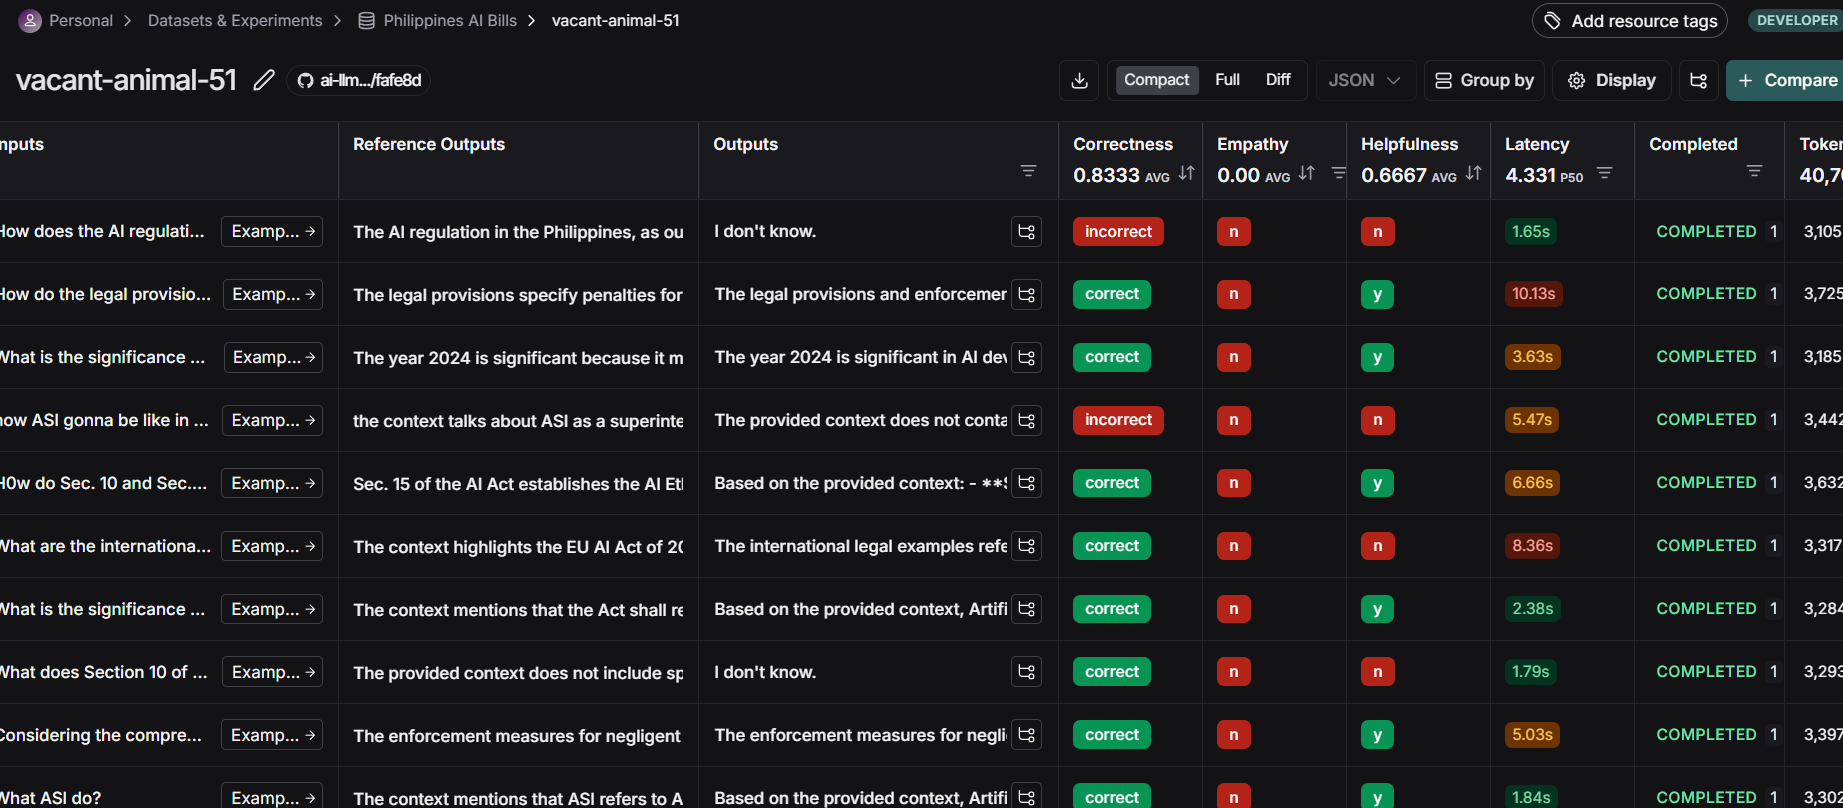
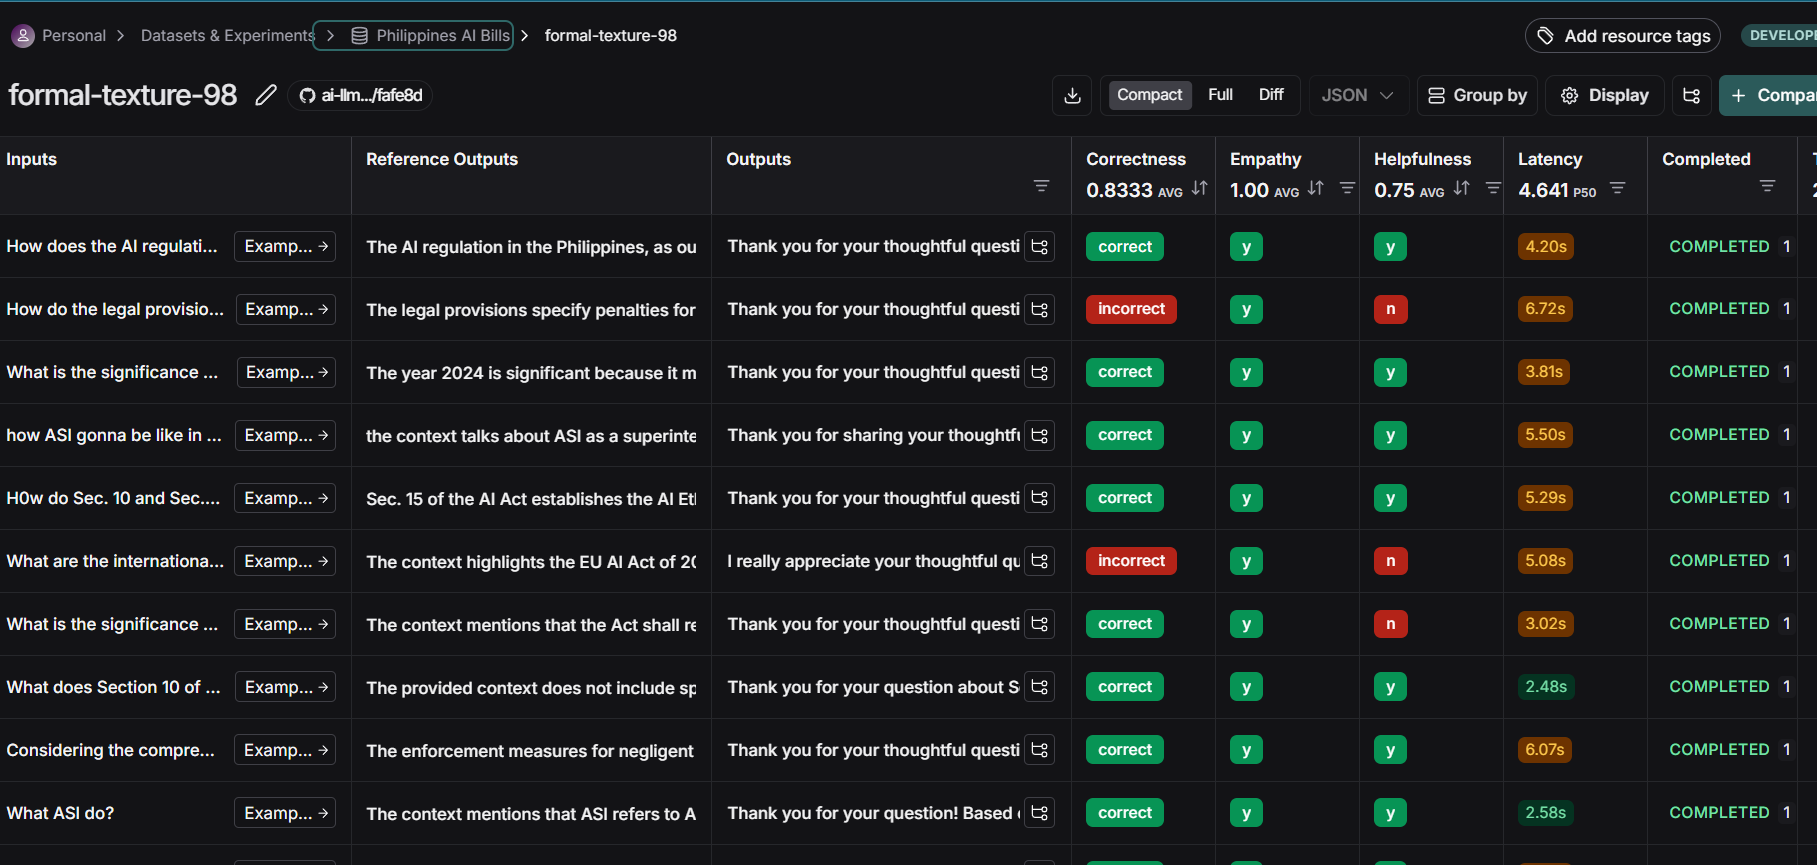

The two screenshots compare two chains. The biggest changes are in Empathy and Helpfulness. In formal-texture-98, the model consistently provides polite, human-like, and empathetic responses such as “Thank you for your thoughtful question”, which raises Empathy to 1.00 and Helpfulness to 0.75. In contrast, vacant-animal-51 delivers blunt, minimal answers like “I don’t know” or simply restating the context, causing Empathy to drop to 0.00 and Helpfulness to 0.6667. Notably, Correctness remains the same for both, indicating factual accuracy did not change 

</div>